# 设计

## 类图设计

- 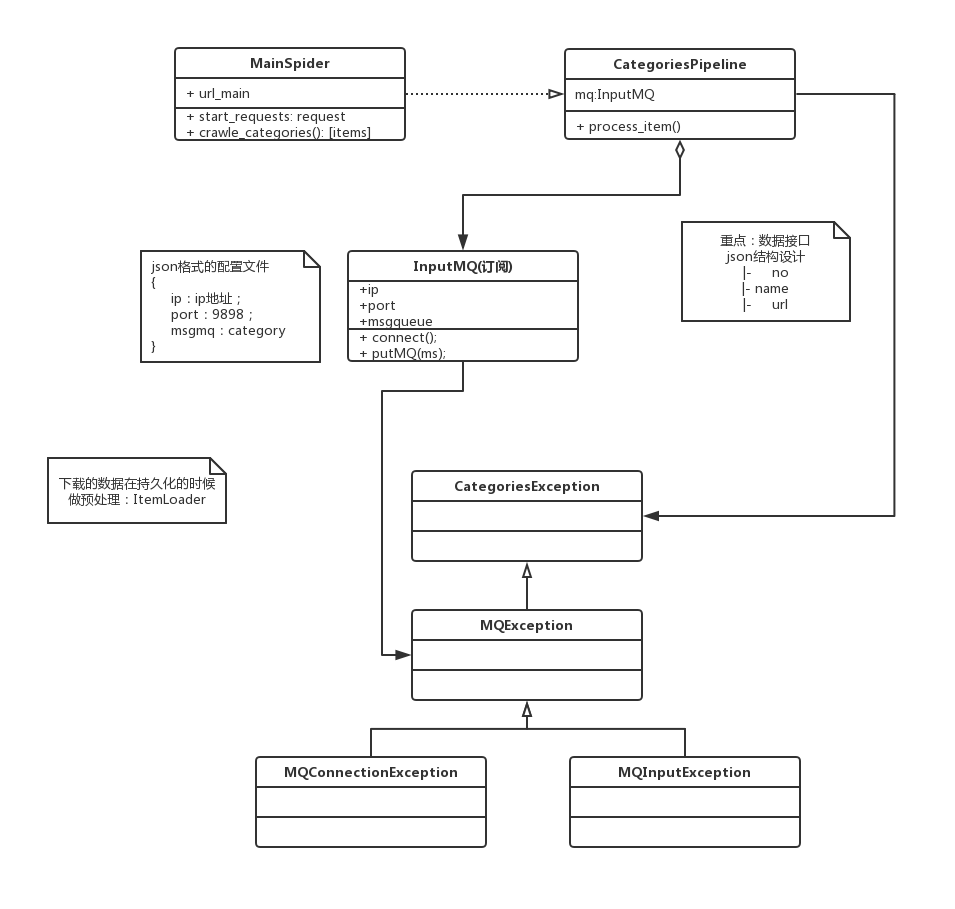

## 数据接口设计

- 爬取的数据接口格式：

```python
{
    type:    分类的大类别；
    name：分类名称；
    url：    分类的爬取链接；
}
```

## 配置文件设计

- 消息队列的链接参数配置：
    - 使用json文本文件：便于手工配置；
    - 格式：
    
```python
{
    ip:                 IP地址
    port:              端口
    msgmq:         消息队列通道
    username:      用户名
    password:      口令
}

```



# 项目结构

- 使用scrapy模式化的项目结构

- 使用scrapy创建项目结构
```bash
    scrapy startproject categories
```

- 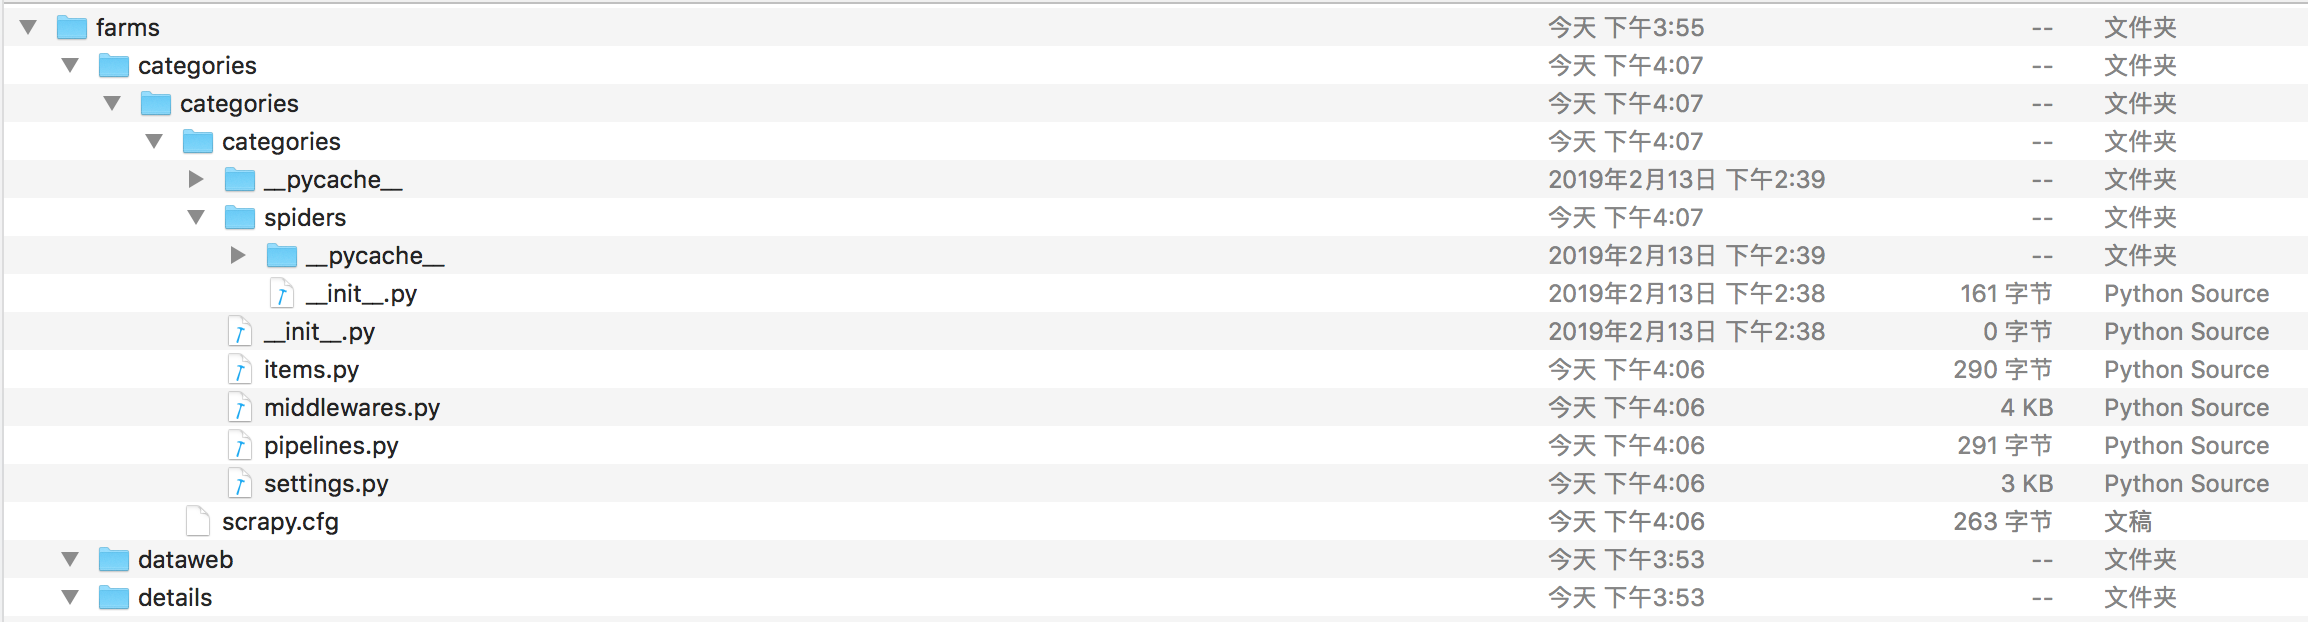

# 主页分类信息爬取代码实现



## 创建爬虫

```python
    scrapy genspider CategoriesSpider www.zgncpw.com
```

In [ ]:
# -*- coding: utf-8 -*-
import scrapy


class CategoriesspiderSpider(scrapy.Spider):
    name = 'CategoriesSpider'
    allowed_domains = ['http://www.zgncpw.com']
    start_urls = ['http://www.zgncpw.com/']

    def parse(self, response):
        pass


## 爬虫配置

### 爬取时间配置

```python
DOWNLOAD_DELAY = 5
```

### cookie的配置
```python
COOKIES_ENABLED = True
```

### 请求并发数
```python

CONCURRENT_REQUESTS = 8
```

### 用户代理配置

#### 实现用户代理的代码

In [ ]:
from scrapy.downloadermiddlewares.useragent import UserAgentMiddleware


class CategoriesUserAgentMiddleware(UserAgentMiddleware):
    UserAgents = [
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:66.0) Gecko/20100101 Firefox/66.0'
    ]

    def process_request(self, request, spider):
        # 先随机选择一个用户代理
        current_ua = random.choice(self.UserAgents)
        request.headers.setdefault('User-Agent', current_ua)


#### 配置用户代理的设置

```python
    DOWNLOADER_MIDDLEWARES = {
        # 'categories.middlewares.CategoriesDownloaderMiddleware': 543,
        'categories.middlewares.CategoriesUserAgentMiddleware': 545
    }
```

### IP代理池

#### 实现IP代理池的代码

In [ ]:
from scrapy.downloadermiddlewares.httpproxy import HttpProxyMiddleware
import random


class IPProxyPoolMiddleware(HttpProxyMiddleware):
    IPProxyPools = [
        {"ipaddr": "192.168.1.6:80"},
        {"ipaddr": "192.168.1.7:80"},
        {"ipaddr": "192.168.1.8:80"}]

    def process_request(self, request, spider):
        # 随机选择一个IP
        current_ip = random.choice(self.IPProxyPools)
        # 设置元数据
        request.meta["proxy"] = "http://" + current_ip["ipaddr"]

- 注意：
    - 由于没有有效的代理IP，所以这个配置可以暂时关闭；

#### 配置IP代理池配置

```python

    DOWNLOADER_MIDDLEWARES = {
        # 'categories.middlewares.CategoriesDownloaderMiddleware': 543,
        'categories.middlewares.IPProxyPoolMiddleware': 544,
        'categories.middlewares.CategoriesUserAgentMiddleware': 545
    }

```

## 实现农产品分类信息爬取

- 为了扩展，把默认的模板结构改成原生结构

### 定义采集的数据结构

In [ ]:
import scrapy


class CategoriesItem(scrapy.Item):
    # define the fields for your item here like:
    # name = scrapy.Field()
    type = scrapy.Field()
    name = scrapy.Field()
    url = scrapy.Field()


### 配置ItemPipe

```python

    ITEM_PIPELINES = {
       'categories.pipelines.CategoriesPipeline': 300,
    }

```

### 爬虫的实现

In [ ]:
# -*- coding: utf-8 -*-
import scrapy
from scrapy.http import Request
from categories.items import CategoriesItem

class CategoriesspiderSpider(scrapy.Spider):
    name = 'CategoriesSpider'
    allowed_domains = ['http://www.zgncpw.com']
    start_urls = ['http://www.zgncpw.com/']
    counter = 0

    # 启动爬取的首页
    def start_requests(self):
        for start_url in self.start_urls:   # 可以支持多个首页
            yield Request(
                url=start_url,
                callback=self.crawle_categories,
                method='GET',
                dont_filter=True)

    # 解析首页的农产品分类数据
    def crawle_categories(self, response):
        # 获取主菜单的农产品一级分类节点
        str_xpath = '//*[@id="top-menu"]/div/div/ul/li[@class="sub-menu pos-rel one"]/ul/li'
        all_categories = response.xpath(str_xpath)
        for categories in all_categories:
            # 解析出一级分类名
            category_type = categories.xpath('@title').get()
            # 循环解析二级分类节点
            type_categories = categories.xpath('ul/li')
            for category in type_categories:
                # 存放解析的一条数据
                item = CategoriesItem()
                # 一级分类名
                item['type'] = category_type
                # 二级分类名
                item['name'] = category.xpath('b/a/text()').get()
                # 二级分类的农产品销售信息页面链接URL
                item['url'] = category.xpath('b/a/@href').get()
                yield item


- 运行效果
    - 总共类别347类。
    - 因为数据比较规则，所以没有特别的数据为空的处理代码。
    - 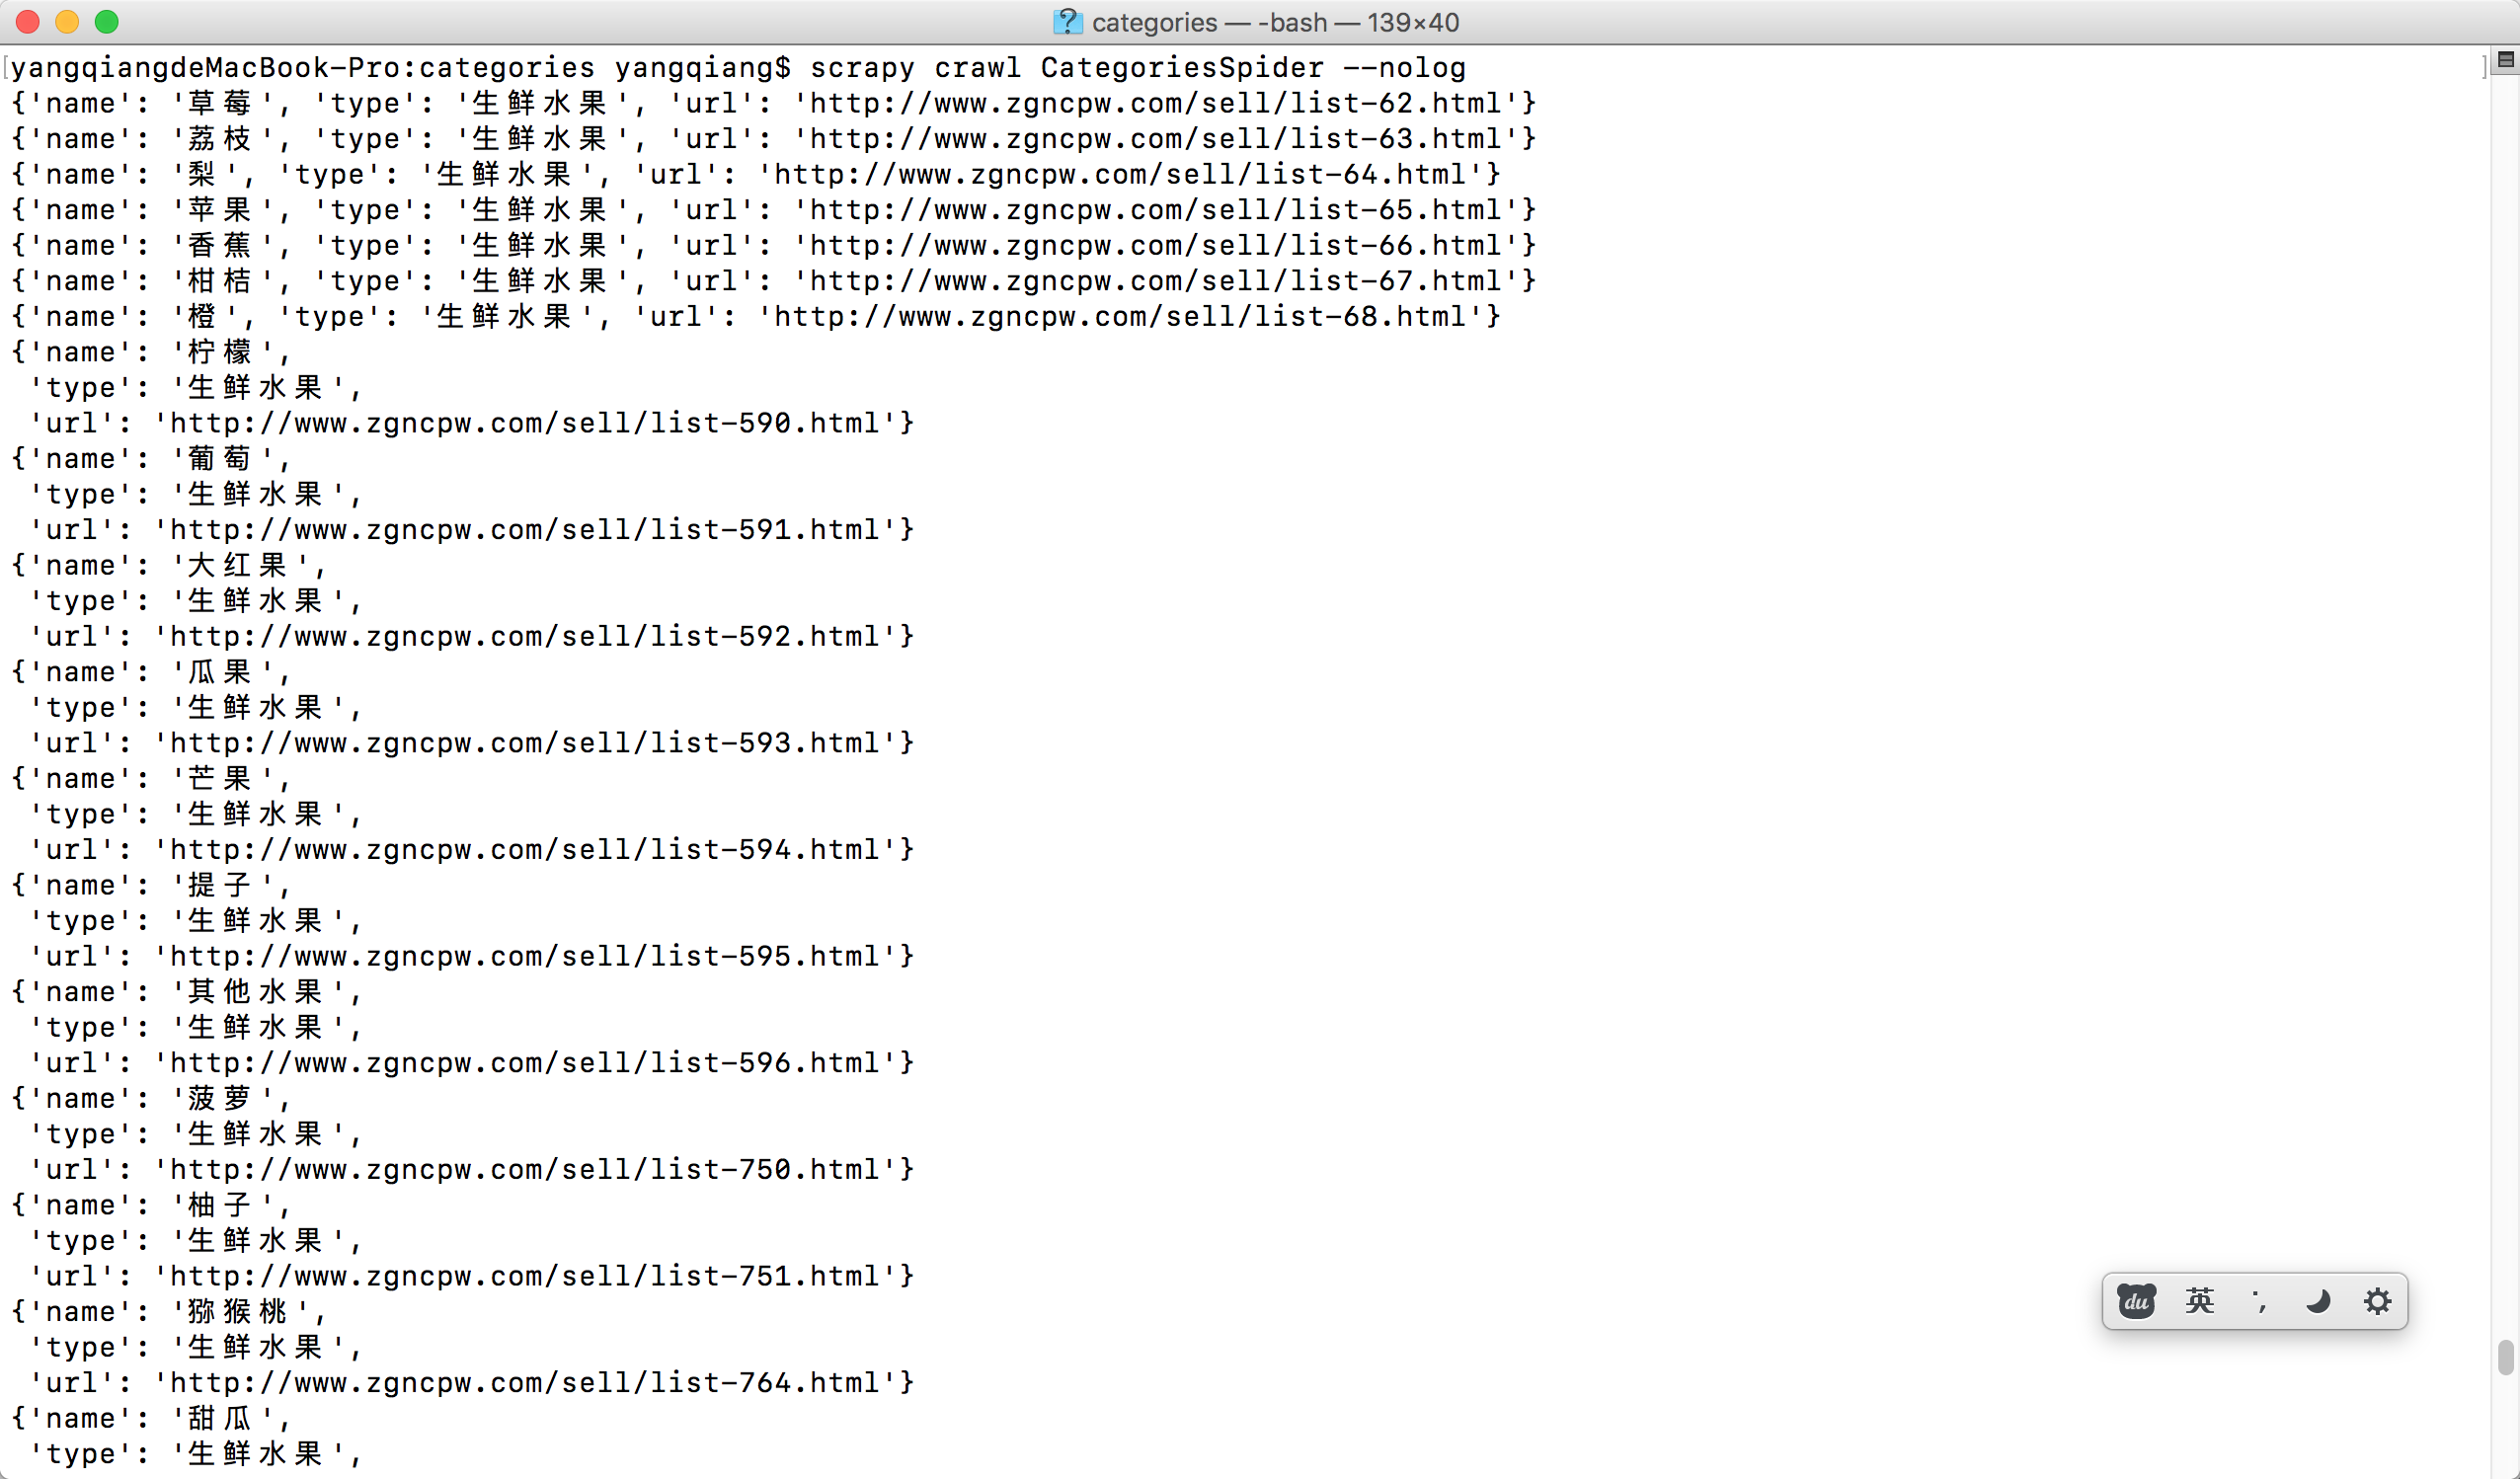

# Redis消息队列服务器

## 修改Redis的配置文件

- 使用安装Redis的配置文件直接修改redis.conf
    - 其中只修改数据库存放目录为/data
    
- 参考我们提供的redis.conf文件

## 创建Redis的Dockerfile

- 端口映射
- 数据存储目录挂载
- 配置文件拷贝

- 说明：参考我们提供的Docker文件

```bash

    # 基础镜像
    FROM redis

    # 镜像维护者
    MAINTAINER Louis Young

    # 拷贝本地的Redis配置文件到容器内
    COPY ./redis.conf  /etc/

    # 映射端口，在docker命令中使用-p指定宿主端口与容器端口映射（-p 宿主端口：容器端口）
    EXPOSE 6379

    # 挂载外部目录（自动挂载非指定目录），在docker命令中使用-v选项挂载指定宿主目录与容器目录（-v 宿主目录：容器目录）
    # VOLUME ["/data",]

    # 启动Redis服务器(也可以使用docker启动服务器，docker启动更加灵活)
    # CMD ["redis-server",]

```

## 构建镜像

- 说明：参考我们提供的create_container.sh文件

```bash

    # 创建docker容器
    docker build -t redis:2019.06 ./

```

## 启动Redis服务

- 说明：参考我们提供的start_container.sh文件。

```bash

    # 启动docker容器
    docker run -itd -p 6379:6379 -v ${PWD}/data:/data redis:2019.06 redis-server /etc/redis.conf --appendonly yes 

    # -it 交互模式
    # -d 后台启动
    # -p 映射宿主机端口：容器端口
    # -v 挂载宿主机目录：容器目录

```

## 进入后台docker容器执行命令

1. 使用：docker查看运行的docker容器

```bash
bogon:~ yangqiang$ docker ps

###########################
CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS              PORTS                    NAMES
e835c0005930        redis:2019.06       "docker-entrypoint.s…"   35 minutes ago      Up 35 minutes       0.0.0.0:6379->6379/tcp   boring_aryabhata
bogon:~ yangqiang$ 
```

2. 在运行的容器中执行指令

```bash
bogon:~ yangqiang$ docker exec boring_aryabhata   ls /usr/local/bin

###########################
docker-entrypoint.sh
gosu
redis-benchmark
redis-check-aof
redis-check-rdb
redis-cli
redis-sentinel
redis-server
bogon:~ yangqiang$ 
```

3. 在运行的容器中执行内部命令

```bash

    docker exec boring_aryabhata   /bin/bash -c 'kill -9 1'


```


- 说明：使用容器内部执行指令的方式，可以执行ps，kill指令关闭进程。
    - 有的redis镜像，没有ps，cd，top等指令。

3. 使用docker来终止容器运行

```python
    docker stop $CONTAINER_ID
```

- 使用`docker ps`查看运行的容器就可以关闭。

## 远程访问的保护

- 如果远程访问，要么设置授权码，要么设置保护模式为no

```
    protected-mode no
```

- 注释ip绑定，开放所有ip，或者指定ip列表。

```bash

# bind 127.0.0.1

```

# 发送农产品类别到任务队列

## Redis任务队列封装

```python

import redis.client
import json

class RedisMQ(object):
    ip = '127.0.0.1'
    port = 6379
    db = 0
    key = 'category_task'
    conn = None

    def __init__(self, key_='category_task'):
        self.key = key_
        # 链接服务器（考虑异常处理）
        self.conn = redis.client.Redis(host=self.ip, port=self.port, db=self.db)

    # 链接redis数据库（需要的时候重新调用）
    def connect(self):
        try:
            self.conn = redis.client.Redis(host=self.ip, port=self.port, db=self.db)
        except Exception as e:
            raise Exception()

    # 把分类的爬取任务放入任务队列
    def push_task(self, item):
        # 这里考虑异常处理
        self.conn.rpush(self.key, item)

    # 获取任务队列
    def pop_task(self):
        # 使用阻塞队列（注意返回元组（key ，value），key是队列的key）
        return self.conn.blpop(self.key, timeout=60) # 延时时间单位为秒


# mq = RedisMQ()
# re = mq.pop_task()
# print(re[0], re[1])
# ff = json.loads(re[1])

```

## 使用Redis队列发送任务队列


```python

from categories.dbs.redismq import RedisMQ
import json


class CategoriesPipeline(object):
    redis_mq = RedisMQ()

    def process_item(self, item, spider):
        # 做一下简单的json格式处理
        content = json.dumps(dict(item), ensure_ascii=False)
        # 发送采集任务到队列
        self.redis_mq.push_task(content)
        return item


```